# Metrics for Hyperparameter Tuning

**AUC**
- AUC is a threshold-independent metric that focuses on the overall performance of the model across all possible threshold values.
- It is useful when you want to evaluate the model’s ability to distinguish between positive and negative instances without specifying a threshold.
- AUC is particularly useful in scenarios with imbalanced classes or when the cost of false positives and false negatives is similar.
- AUC is often used in binary classification problems where the goal is to maximize the overall classification accuracy.

**F1**
- It is useful when you want to optimize the trade-off between precision and recall for a specific threshold.
- It is sensitive to class imbalance (optimizes for the majority class if not weighted).
- Requires defining a threshold (default = 0.5, which may not be optimal).

**Hybrid approach**
- Optimize AUC first, then tune thresholds: Use AUC for hyperparameter tuning, then adjust the threshold post-training based on F1.
- You can also use F beta when adjusting the threshold, which allows you to balance precision and recall while considering the cost of false positives and false negatives for your specific use case.

100%|██████████| 20/20 [00:03<00:00,  5.48trial/s, best loss: 0.3017456359102244]

Test Performance Comparison:
AUC-Optimized:
  AUC = 0.975, F1 = 0.762
F1-Optimized:
  AUC = 0.978, F1 = 0.766
Hybrid:
  AUC = 0.975, F1 = 0.813


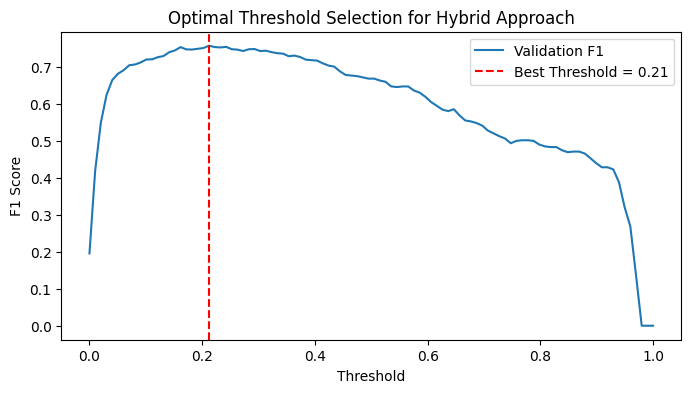

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
import lightgbm as lgb
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Load data
# data = load_breast_cancer()
# X, y = data.data, data.target

# Generate synthetic imbalanced dataset (98:2 class ratio)
X, y = make_classification(
    n_samples=10000,
    n_features=20,  
    n_classes=2,
    weights=[0.9, 0.1],  
    random_state=42
)

# Split into train (60%), validation (20%), test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Define hyperparameter search space for Hyperopt
space = {
    'num_leaves': hp.choice('num_leaves', [15, 31, 63]),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'n_estimators': hp.choice('n_estimators', [50, 100, 200]),
    'min_child_samples': hp.choice('min_child_samples', [10, 20, 30]),
}

# ---------------------------
# Helper functions
# ---------------------------
def train_evaluate(params, metric='auc'):
    """Train a model and evaluate on validation set."""
    model = lgb.LGBMClassifier(
        **params,
        random_state=42,
        verbose=-1
    )
    model.fit(X_train, y_train)
    
    y_val_proba = model.predict_proba(X_val)[:, 1]
    
    if metric == 'auc':
        score = roc_auc_score(y_val, y_val_proba)
        loss = 1 - score  
    elif metric == 'f1':
        y_pred = (y_val_proba >= 0.5).astype(int)
        score = f1_score(y_val, y_pred)
        loss = 1 - score
    else:
        raise ValueError("Invalid metric")
    
    return {'loss': loss, 'status': STATUS_OK, 'model': model}

# ---------------------------
# Approach 1: Optimize for AUC with Hyperopt
# ---------------------------
def objective_auc(params):
    return train_evaluate(params, metric='auc')

trials_auc = Trials()
best_auc = fmin(
    fn=objective_auc,
    space=space,
    algo=tpe.suggest,
    max_evals=20,  # Adjust for computational budget
    trials=trials_auc,
    rstate=np.random.default_rng(42)
)
best_auc_model = trials_auc.best_trial['result']['model']

# ---------------------------
# Approach 2: Optimize for F1 with Hyperopt
# ---------------------------
def objective_f1(params):
    return train_evaluate(params, metric='f1')

trials_f1 = Trials()
best_f1 = fmin(
    fn=objective_f1,
    space=space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials_f1,
    rstate=np.random.default_rng(42)
)
best_f1_model = trials_f1.best_trial['result']['model']

# ---------------------------
# Approach 3: Hybrid (AUC + Threshold Tuning)
# ---------------------------
# Use best AUC model from Approach 1
y_val_proba = best_auc_model.predict_proba(X_val)[:, 1]

# Find optimal F1 threshold
thresholds = np.linspace(0, 1, 100)
f1_scores = [f1_score(y_val, (y_val_proba >= t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]

# ---------------------------
# Evaluate All Approaches on Test Set
# ---------------------------
def evaluate_model(model, X_test, y_test, threshold=0.5):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    return {
        'AUC': roc_auc_score(y_test, y_proba),
        'F1': f1_score(y_test, y_pred)
    }

results = {
    'AUC-Optimized': evaluate_model(best_auc_model, X_test, y_test),
    'F1-Optimized': evaluate_model(best_f1_model, X_test, y_test),
    'Hybrid': evaluate_model(best_auc_model, X_test, y_test, best_threshold)
}

print("\nTest Performance Comparison:")
for approach, metrics in results.items():
    print(f"{approach}:")
    print(f"  AUC = {metrics['AUC']:.3f}, F1 = {metrics['F1']:.3f}")

# Plot threshold tuning
plt.figure(figsize=(8, 4))
plt.plot(thresholds, f1_scores, label='Validation F1')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('Optimal Threshold Selection for Hybrid Approach')
plt.legend()
plt.show()